<a href="https://colab.research.google.com/github/alonsomoros/colab/blob/main/2_3_Auto_encoders_Reducci%C3%B3n_de_ruido_Soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div><img style="float: right; width: 80px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Reducción de ruido con autoencoders<a id="top"></a>

<i><small>Authors: Félix José Fuentes Hurtado<br>Last update: 2023-09-29</small></i></div>

***

### Reducción de ruido con autoencoders

En este notebook vamos a ver cómo podemos implementar un autoencoder convolucional y utilizarlo para reducir el ruido presente en los datos de entrada. Todos los ejemplos están extraídos del propio blog de Keras, aquí tenéis el [enlace](https://blog.keras.io/building-autoencoders-in-keras.html) para su consulta.

Comenzemos recordando qué es un autoencoder convolucional. Para ello, mirad la imagen siguiente:

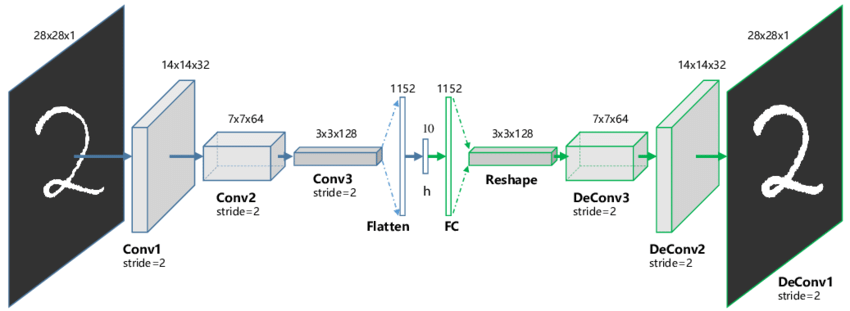

En ella podemos observar como consta de dos bloques: el encoder y el decoder.

Por una parte, el **encoder** toma los datos de entrada y los comprime en una representación mucho más compacta.

Por la otra, el **decoder** coge esa representación (o codificación) comprimida y trata de reconstruir los datos originales con el menor error posible.

A lo largo de esta práctica implementaremos un autoencoder convolucional y lo emplearemos para reducir el ruido de los datos de entrada.

Para ello, primero implementaremos la arquitectura y la probaremos con la tarea de reconstruir los datos simplemente.

Después, añadiremos ruido a las imágenes y reentrenaremos el autoencoder para que lo elimine y produzca la versión limpia de las mismas.

**¡Comenzemos!**

Vamos a implementar nuestro primer autoencoder convolucional. La arquitectura del autoencoder será la siguiente:

Para el encoder:

- Capa Convolucional, 16 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`
- Capa Convolucional, 8 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`
- Capa Convolucional, 4 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`

Para el decoder:

- Capa Convolucional, 4 filtros de 3x3, activación `ReLU` y padding `same`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 8 filtros de 3x3, activación `ReLU` y padding `same`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 16 filtros de 3x3, activación `ReLU` y padding `valid`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 1 filtros de 3x3, activación `sigmoid` y padding `same`


**Pregunta**: ¿Qué tamaño tendrá el bottleneck?

**Respuesta**: Yendo de capa en capa desde la entrada: (28, 28, 1) --> (28, 28, 16) --> (14, 14, 16) --> (14, 14, 8) --> (7, 7, 4) --> (4, 4, 4)

En el último paso, al hacer el último pooling, pasaremos de 7x7 a 4x4, ya que irá obteniendo el máximo de cada región 2x2. Como la entrada tiene 7x7, en el último paso no tendrá 2x2 sino 2x1.

In [7]:
import keras
from keras import layers

In [8]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 4) i.e. 64-dimensional

x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Ahora obtendremos las imágenes y las normalizaremos entre 0 y 1: dividiremos entre 255, ya que las imágenes están codificadas con 8 bits sin signo (uint8).

In [9]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255

Como vamos a trabajar con imágenes, tenemos que redimensionar los datos para que tengan 2 dimensiones: de 786 a (28, 28, 1), porque son imágenes en escala de grises.

In [10]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Tras esto, entrenamos nuestro DC (Deep Convolutional) AutoEncoder:

*(Atención: ahora es importante tener seleccionada GPU o TPU, de lo contrario el entrenaiento será muy lento)*

In [11]:
logs = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 128ms/step - loss: 0.3445 - val_loss: 0.1762
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step - loss: 0.1714 - val_loss: 0.1581
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 130ms/step - loss: 0.1563 - val_loss: 0.1478
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - loss: 0.1472 - val_loss: 0.1390
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - loss: 0.1387 - val_loss: 0.1339
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - loss: 0.1343 - val_loss: 0.1307
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - loss: 0.1313 - val_loss: 0.1285
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - loss: 0.1293 - val_loss: 0.1269
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 130ms/step - loss: 0.1278 - val_loss: 0.1254
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 127ms/step - loss: 0.1264 - val_loss: 0.1247


También podemos visualizar las curvas de entrenamiento, que se guardan en la variable history:

In [12]:
logs.history.keys()

dict_keys(['loss', 'val_loss'])

In [13]:
import matplotlib.pyplot as plt

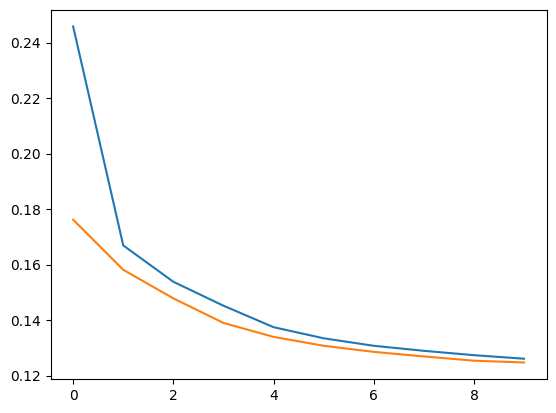

In [14]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


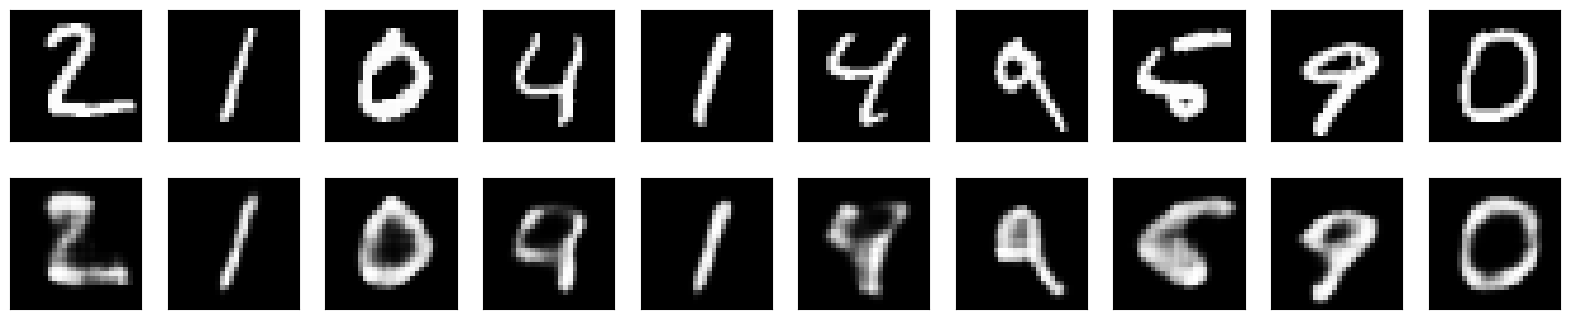

In [16]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Ya hemos conseguido entrenar nuestro autoencoder para que reconstruya los datos de entrada.

Ahora probaremos a añadirle ruido a las imágenes y lo entrenaremos para que lo elimine. De esta forma, la entrada serán imágenes ruidosas y la salida imágenes limpias. O eso deseamos.

Vamos a generar ruido sintético en nuestras imágenes y a tratar de eliminarlo con nuestro modelo.

In [17]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Veamos qué es lo que hemos hecho. Vamos a visualizar las imágenes originales y después las "ruidosas":

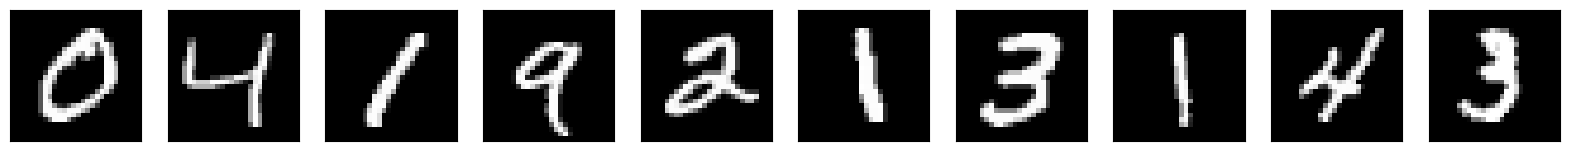

In [18]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

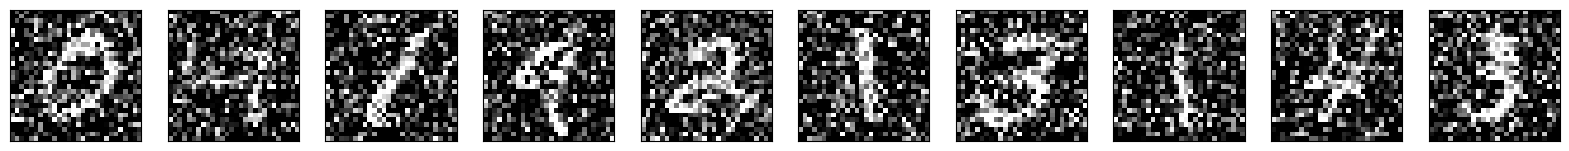

In [19]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

En efecto, hemos añadido una cantidad de ruido considerable. Vamos a intentar eliminarlo con un el autoencoder convolucional que hemos implementado anteriormente:

In [21]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 4) i.e. 64-dimensional

x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

logs = autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 131ms/step - loss: 0.3722 - val_loss: 0.1991
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 62s 133ms/step - loss: 0.1954 - val_loss: 0.1804
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - loss: 0.1789 - val_loss: 0.1716
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 134ms/step - loss: 0.1716 - val_loss: 0.1667
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 65s 140ms/step - loss: 0.1673 - val_loss: 0.1633
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - loss: 0.1639 - val_loss: 0.1605
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - loss: 0.1611 - val_loss: 0.1585
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - loss: 0.1593 - val_loss: 0.1569
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 132ms/step - loss: 0.1577 - val_loss: 0.1553
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 135ms/step - loss: 0.1564 - val_loss: 0.1538


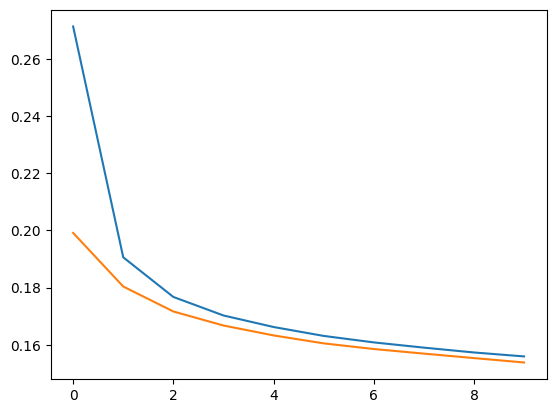

In [22]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

Visualicemos ahora los resultados, a ver qué hemos conseguido:

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


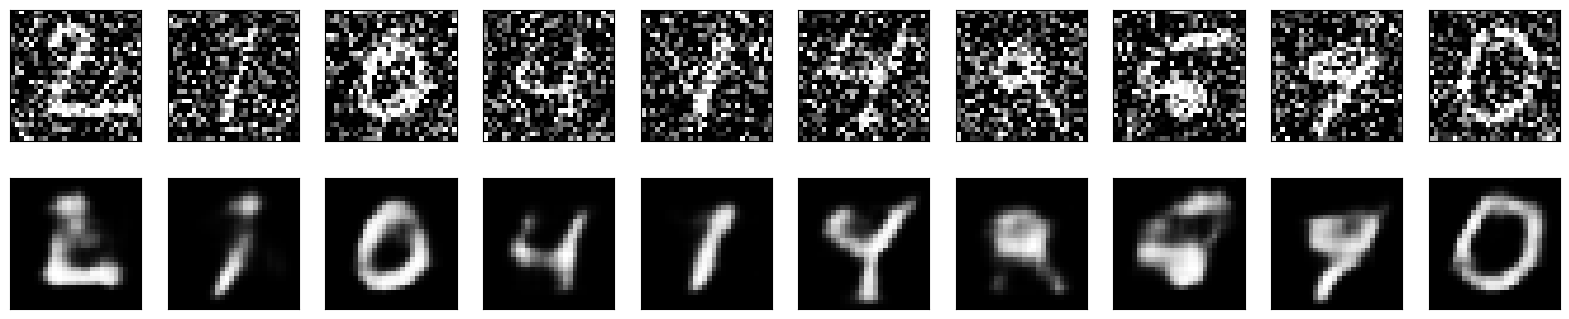

In [23]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


¿Qué os parece? Nada mal, ¿no? ¡Hemos conseguido eliminar totalmente el ruido!

### Pregunta: ¿Cuánto créeis que podéis simplificar la arquitectura y que todavía funcione?

Probad con la siguiente arquitectura:


Para el encoder:

- Capa Convolucional, 4 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`
- Capa Convolucional, 2 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`
- Capa Convolucional, 1 filtros de 3x3, activación `ReLU` y padding `same`
- Capa MaxPooling2D, tamaño de pooling 2x2, padding `same`

Para el decoder:

- Capa Convolucional, 1 filtros de 3x3, activación `ReLU` y padding `same`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 2 filtros de 3x3, activación `ReLU` y padding `same`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 4 filtros de 3x3, activación `ReLU` y padding `same`
- Capa UpSampling2D, factor de upsample 2x2
- Capa Convolucional, 1 filtros de 3x3, activación `sigmoid` y padding `same`


**Pregunta**: ¿Qué tamaño tendrá el bottleneck?

**Respuesta**: Yendo de capa en capa desde la entrada: (28, 28, 1) --> (28, 28, 4) --> (14, 14, 4) --> (14, 14, 2) --> (7, 7, 2) --> (4, 4, 1)

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (4, 4, 1)

x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(4, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

logs = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
469/469 [==============================] - 6s 7ms/step - loss: 0.3584 - val_loss: 0.2642
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2431 - val_loss: 0.2337
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2296 - val_loss: 0.2269
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2232 - val_loss: 0.2207
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2192 - val_loss: 0.2174
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2162 - val_loss: 0.2148
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.2141 - val_loss: 0.2133
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2129 - val_loss: 0.2122
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2120 - val_loss: 0.2113
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2112 - val_loss: 0.2106

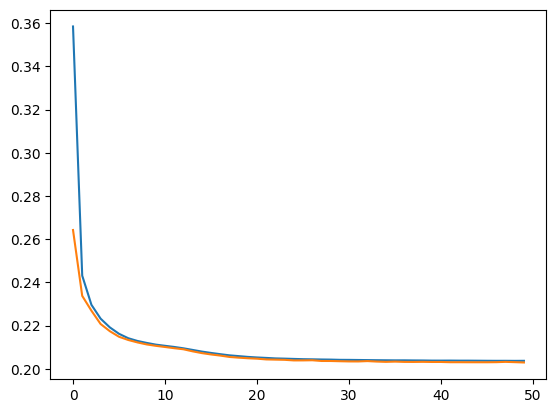

In [ ]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

313/313 [==============================] - 1s 3ms/step


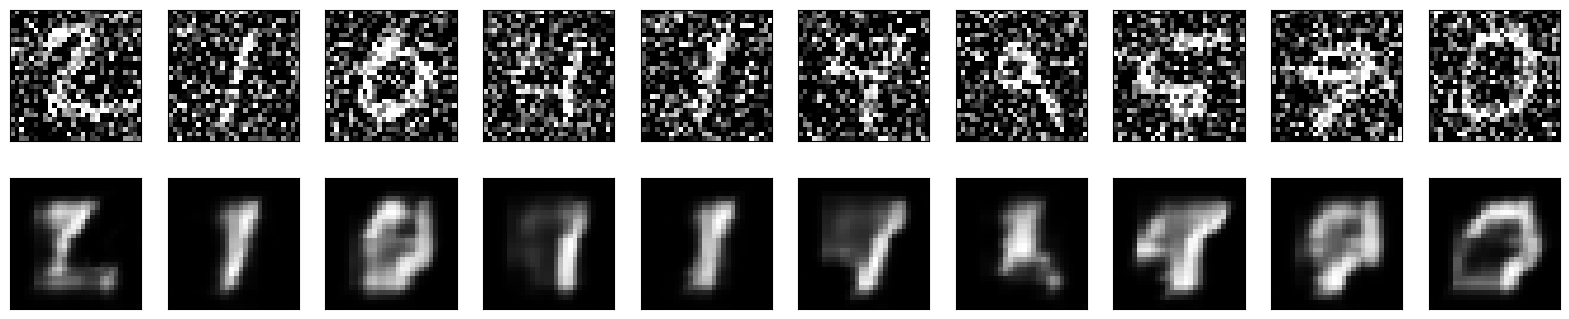

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Parece que con un bottleneck con un código latente de 16 elementos (`4x4x1`) no es suficiente.

### Ejercicio

**Modifíca la arquitectura hasta conseguir el mínimo código latente que consiga eliminar el ruido de las imágenes de forma satisfactoria.**

*TIP*: Puedes probar con espacios latentes de `32 elementos (4, 4, 2)`, `48 elementos (4, 4, 3)` y `64 elementos (4, 4, 4)`. Recuerda que la estructura del encoder-decoder es tal que el encoder reduce las dimensiones y el decoder las aumenta.

Epoch 1/50
469/469 [==============================] - 6s 8ms/step - loss: 0.3007 - val_loss: 0.2416
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.2123 - val_loss: 0.1983
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1924 - val_loss: 0.1873
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1846 - val_loss: 0.1800
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1780 - val_loss: 0.1743
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1729 - val_loss: 0.1699
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1691 - val_loss: 0.1665
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1663 - val_loss: 0.1643
Epoch 9/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1643 - val_loss: 0.1627
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1628 - val_loss: 0.1612

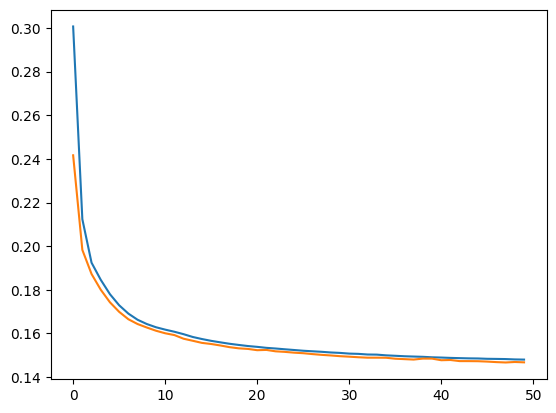

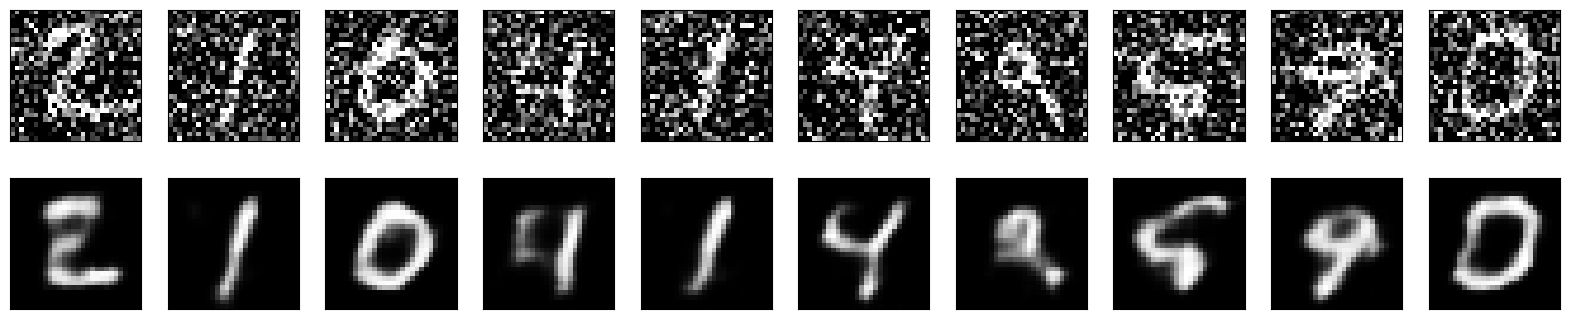

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (4, 4, 3)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(6, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

logs = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])

decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Podemos observar que un tamaño de 48 elementos para el espacio latente o *bottleneck* (`4x4x3`) empieza a ser suficiente para este sencillo problema.

El tamaño y complejidad del autoencoder dependerá, principalmente, de la dificultad del problema y de los datos.